Attempting to Determine a Threshold for Similarity between 10Qs and a sample legal document 

In [32]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from nltk import tokenize
import seaborn
from sklearn import metrics
from preprocessing.legal_filter import file_to_sents, get_legal_bank


### Download Universal Sentence Encoder 

In [9]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [36]:
logging.set_verbosity(logging.ERROR)
legal_vectors = model(get_legal_bank())

In [37]:
# get the sections associates with one particular 10Q
company_code = "AAPL"
release_date = "20180331"
comp_dir = os.path.join(os.path.expanduser("../resources/itemized"), company_code)

sections = {}
for root, dirs, files in os.walk(comp_dir):
    for file in files: 
        if release_date in file:
            # get the section identifier (i.e. part2, item1, etc)
            identifier = file.split("_")[3].replace(".txt", "")
            
            sections[identifier] = file

In [38]:
sect_score_maxes = {}
for sect_id, sect in sections.items():
    sents = file_to_sents(os.path.join(comp_dir, sect))
    doc_vectors = model(sents)
    cosine = metrics.pairwise.cosine_similarity(doc_vectors, legal_vectors)    
    score_maxes = np.amax(cosine, axis=1)
    sect_score_maxes[sect_id] = score_maxes

# Exploring Cosine Similarity

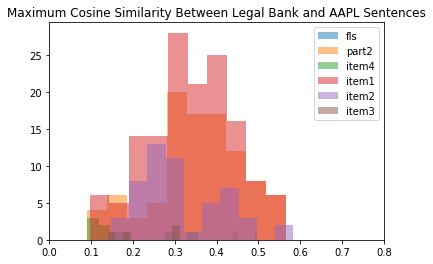

In [41]:
## plot histogram 
# sns.distplot()

for sect_id, score_maxes in sect_score_maxes.items():
    plt.hist(score_maxes, label = sect_id, alpha = 0.5)
#     plt.axvline(np.median(score_maxes), color = 'r')
    # plt.axvline(np.mean(score_maxes), color = 'g')
plt.xticks(np.arange(0.0, 0.9, 0.1))
plt.title("Maximum Cosine Similarity Between Legal Bank and " + company_code + " Sentences")
plt.legend(loc='upper right')
plt.show()




In [ ]:
# %matplotlib ipympl

sns.heatmap(cosine,cmap="YlGnBu")

plt.title("Cosine Similarity Heatmap between Apple 10Q and Set of Cautionary Statements")
plt.ylabel("2018 Apple 10Q")
plt.xlabel("Set of Forward Looking Statments")

plt.show()


In [ ]:
thresh = 0.9
idcs = np.where(np.logical_and(cosine > 0.28, cosine < 0.3))
np.shape(idcs)
idcs
# print(non_empty[6])

In [ ]:
print(non_empty[26])